In [49]:
#import necessary modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import lightgbm as lgb
import geopandas as gdp

#files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [50]:
#import dataset 
df = pd.read_csv(r'C:/Users/foeke/OneDrive/Documenten/submitting paper/All scripts - paper/data/GlobalModelData/ModellingDataset-Global.csv', sep=';')


# Dataset Preparation

In [51]:
pd.set_option('display.max_columns', None)
df.head()

,FID,Longitude,Latitude,wkd_day_value,wnd_day_value,wkd_night_value,wnd_night_value,mean_value_NO2,radiation,nightlight_450,nightlight_4950,nightlight_3150,nightlight_900,elevation,industry_1000,industry_100,industry_25,industry_3000,industry_300,industry_5000,industry_500,industry_50,population_1000,population_3000,population_5000,road_class_1_1000,road_class_1_100,road_class_1_25,road_class_1_3000,road_class_1_300,road_class_1_5000,road_class_1_500,road_class_1_50,road_class_2_1000,road_class_2_100,road_class_2_25,road_class_2_3000,road_class_2_300,road_class_2_5000,road_class_2_500,road_class_2_50,road_class_3_1000,road_class_3_100,road_class_3_25,road_class_3_3000,road_class_3_300,road_class_3_5000,road_class_3_500,road_class_3_50,temperature_2m_10,temperature_2m_11,temperature_2m_12,temperature_2m_1,temperature_2m_2,temperature_2m_3,temperature_2m_4,temperature_2m_5,temperature_2m_6,temperature_2m_7,temperature_2m_8,temperature_2m_9,TROP_2018,wind_speed_10m_10,wind_speed_10m_11,wind_speed_10m_12,wind_speed_10m_1,wind_speed_10m_2,wind_speed_10m_3,wind_speed_10m_4,wind_speed_10m_5,wind_speed_10m_6,wind_speed_10m_7,wind_speed_10m_8,wind_speed_10m_9,trop_mean_filt_2019,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,BldDen100,BldDen500,BldDen1000,NDVI,trafBuf25,trafBuf50,trafBuf100,trafBuf400,trafBuf800
0,0,10.008293,48.397079,30.711957,24.263388,30.438486,28.947476,29.250500,3.192437,22.585377,8.363607,13.402575,21.461321,473.936554,330625,0,0,4466250,39375,6101250,92500,0,8123.319336,54316.64453,95795.42188,0.00000,0.0,0.0,25200.30273,0.000000,49436.99219,0.000000,0.0,0.000000,0.000000,0.000000,7335.407715,0.000000,28671.41016,0.000000,0.000000,31902.113280,313.874695,67.135361,203502.42190,4167.064941,373058.6875,8838.760742,180.451675,10.528473,3.994838,0.855892,-4.079916,2.809515,6.935457,7.397969,13.671423,18.533785,18.813995,18.982145,12.485922,365.725586,2.585911,2.669442,2.989511,2.531975,2.521507,2.995023,2.301084,1.968707,2.190526,2.260399,1.821999,1.986542,0.000058,32.444660,30.905764,45.278419,86.813194,76.644829,84.025391,139.684372,131.750168,62.195648,54.812149,82.809517,62.866955,1.000663,0.910937,0.882346,2310.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,10.021227,53.523262,36.081548,24.658060,32.506374,26.049035,32.098936,2.766697,23.546194,24.685654,22.862799,23.769573,6.617548,936250,0,0,6596250,19375,16483125,131875,0,9558.207031,76786.28125,215604.75000,11369.98047,0.0,0.0,34764.07031,1696.450439,62711.52344,2980.910156,0.0,0.000000,0.000000,0.000000,8974.225586,0.000000,47182.19922,0.000000,0.000000,14582.227540,440.061707,0.000000,99596.04688,1850.278076,313205.7188,5933.034668,58.030884,12.299079,6.153886,3.775151,0.131844,2.825560,6.828553,7.554647,13.972361,17.087158,17.238230,17.520105,13.991841,470.292419,3.869850,3.246683,3.802317,2.791856,3.617435,3.091028,3.455901,2.932038,3.273580,2.649281,2.828152,2.777970,0.000081,64.174301,52.970375,69.828476,50.332016,78.252930,146.870132,105.720657,64.659004,70.474373,117.034981,84.549225,82.943985,0.978245,0.744309,0.658124,2518.0,0.000000,0.000000,0.000000,3519.916667,3335.471469
2,2,10.053859,53.592301,74.562843,51.863782,42.898774,32.600595,58.703744,2.750459,18.290140,15.945211,16.493486,18.070522,18.593605,2500,0,0,343125,0,1212500,0,0,10471.541020,88439.60938,222648.40630,0.00000,0.0,0.0,0.00000,0.000000,11057.72949,0.000000,0.0,5136.330566,270.224976,46.359188,30608.843750,1437.363037,84130.39844,2333.146484,108.745453,34317.210940,157.915741,10.258605,265563.71880,2016.838379,646760.6250,6662.844727,52.477299,12.236689,6.117405,3.744394,0.196013,2.759445,6.723662,7.453573,13.866946,16.986099,17.125896,17.437189,13.936767,457.479950,3.886321,3.264446,3.828975,2.811795,3.632486,3.095585,3.479126,2.962678,3.304003,2.660490,2.845692,2.803313,0.000076,63.257851,53.338516,68.428001,50.577240,76.791069,146.810501,105.269150,63.642395,72.389526,120.899490,85.652794,83.520721,0.914638,0.847111,0.803237,3216.0,674.791667,674.791667,674.791667,674.79

In [52]:
#replace NA with 0
df=df.fillna(0)
#create unique identifier
df['FID'] = range(1,len(df)+1, 1)

## Filtering

#### see distribtions of variables where selecting on quantile is relevant

In [53]:
df['road_class_3_100'].describe()

count     482.000000
mean      272.058826
std       236.379343
min         0.000000
25%        29.281440
50%       257.587921
75%       406.096954
max      1088.154419
Name: road_class_3_100, dtype: float64

In [54]:
df['population_1000'].describe()

count      482.000000
mean      6154.486286
std       4509.973126
min          0.000000
25%       2204.519532
50%       5945.538330
75%       9036.756348
max      20300.886720
Name: population_1000, dtype: float64

### Filter "Urban" observations

In [55]:
df['Urban'] = np.where(df['population_1000'].gt(df['population_1000'].quantile(0.75)) & (df['road_class_1_100'].gt(0) | df['road_class_2_100'].gt(0) | df['road_class_3_100'].gt(df['road_class_3_100'].quantile(0.75))), 1, 0)
df['Urban'].value_counts()

Urban
0    397
1     85
Name: count, dtype: int64

### Filter "Low Population" (<75%) observations

In [56]:
df['LowPop'] = np.where(df['population_1000'].lt(df['population_1000'].quantile(0.75)) & (df['road_class_1_100'].gt(0) | df['road_class_2_100'].gt(0)  | df['road_class_3_100'].gt(df['road_class_3_100'].quantile(0.75))), 1, 0)
df['LowPop'].value_counts()

LowPop
0    344
1    138
Name: count, dtype: int64

### Filter "Far From Road" observations

In [57]:
df['FarFromRoad'] = np.where(df['Urban'] | df['LowPop'] == 1, 0, 1)
df['FarFromRoad'].value_counts()
    

FarFromRoad
1    259
0    223
Name: count, dtype: int64

### Create one column describing spatial characteristic

In [58]:
def spachar(row):
    if row['Urban'] == 1:
        return 1
    if row['LowPop'] == 1:
        return 2
    if row['FarFromRoad'] == 1:
        return 3
    else:
        return 0

In [59]:
df['spachar'] = df.apply (lambda row: spachar(row), axis=1)

### filter to limit no. columns for analyzing purposes 

In [60]:
df_sel = df[['Longitude', 'Latitude', 'mean_value_NO2', 'population_1000', 'road_class_1_100', 'road_class_2_100', 'road_class_3_100', 'spachar']]

In [61]:
#create different datasets so that NO2 distribution per spatial character can be easily examined

Urb = df_sel.loc[df_sel['spachar'] == 1]
Lowpop = df_sel.loc[df_sel['spachar'] == 2]
FFR = df_sel.loc[df_sel['spachar'] == 3]

In [62]:
Urb['mean_value_NO2'].describe()

count    85.000000
mean     38.864759
std      13.065025
min      15.767615
25%      28.172055
50%      38.076120
75%      47.923019
max      78.881718
Name: mean_value_NO2, dtype: float64

In [63]:
Lowpop['mean_value_NO2'].describe()

count    138.000000
mean      27.601430
std        9.768965
min        7.872379
25%       19.872062
50%       26.875778
75%       34.407483
max       56.705580
Name: mean_value_NO2, dtype: float64

In [64]:
FFR['mean_value_NO2'].describe()

count    259.000000
mean      16.652500
std        8.340674
min        2.121931
25%       10.330954
50%       15.891631
75%       22.517860
max       48.886509
Name: mean_value_NO2, dtype: float64

In [65]:
#export option (geopackage) to examine spatial distribution of different groups (spatial characters)
gdf = gdp.GeoDataFrame(df_sel, geometry=gdp.points_from_xy(df.Longitude, df.Latitude), crs=4326)
gdf.to_file("C:/Users/foeke/OneDrive/Documenten/submitting paper/TooBigData/Grid100/Global_spachar.gpkg", driver="GPKG")

## Remove unnecessary variables before doing model evaluation per group (spatial character)

In [66]:
#remove unique idenifier & geodata
df = df.drop(['Longitude', 'Latitude', 'wkd_day_value', 'wnd_day_value','wkd_night_value', 'wnd_night_value', 'spachar'], axis=1)

## Define Datasets, based on characteristics (e.g. 'Urban', 'LowPop', 'FarFromRoad')

In [67]:
df_urban = df[['FID', 'mean_value_NO2', 'nightlight_450', 'nightlight_3150', 'population_1000', 'population_3000', 'road_class_2_25', 'road_class_3_300', 'road_class_3_3000', 'trop_mean_filt_2019', 'BldDen100', 'NDVI', 'trafBuf25', 'trafBuf50', 'Urban']]
df_lowpop = df[['FID','mean_value_NO2','nightlight_450', 'nightlight_3150', 'population_1000', 'population_3000', 'road_class_2_25',  'road_class_3_300', 'road_class_3_3000', 'trop_mean_filt_2019', 'BldDen100', 'NDVI', 'trafBuf25', 'trafBuf50', 'LowPop']]
df_farfromroad = df[['FID','mean_value_NO2','nightlight_450', 'nightlight_3150', 'population_1000', 'population_3000', 'road_class_2_25', 'road_class_3_300', 'road_class_3_3000', 'trop_mean_filt_2019', 'BldDen100', 'NDVI', 'trafBuf25', 'trafBuf50', 'FarFromRoad']]

In [68]:
#only select rows that correspond to 1 for each characteristic column.
df_urban_TEST = df_urban.loc[df_urban['Urban'] == 1]
df_urban_TRAIN = df_urban.loc[df_urban['Urban'] == 0]
df_lowpop_TEST = df_lowpop.loc[df_lowpop['LowPop'] == 1]
df_lowpop_TRAIN = df_lowpop.loc[df_lowpop['LowPop'] == 0]
df_farfromroad_TEST = df_farfromroad.loc[df_farfromroad['FarFromRoad'] == 1]
df_farfromroad_TRAIN = df_farfromroad.loc[df_farfromroad['FarFromRoad'] == 0]

In [69]:
#get index of column with spatial characteristics. This column will be dropped for the
#modelling which is done via the index
df_urban_TRAIN.columns.get_loc("Urban")
df_lowpop_TRAIN.columns.get_loc("LowPop")
df_farfromroad_TRAIN.columns.get_loc("FarFromRoad")

14

# Model Performance

## Define Models

In [70]:
#models

#Non-linear

#Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, min_samples_split=10,
                          min_samples_leaf=5,max_features=4,max_depth=10, bootstrap=True )

#LightGBM
lightgbm_model = lgb.LGBMRegressor(reg_alpha =2, reg_lambda = 0, max_depth = 5, learning_rate = 0.0005, n_estimators =50000, random_state=42)
#XGBoost
xgb= xgb.XGBRegressor(gamma = 5,  reg_alpha =2, reg_lambda=0, max_depth = 5, learning_rate = 0.0005, n_estimators=50000, random_state=42)


#linear models

#Lasso
model_lasso = Lasso(alpha=0.1)
#Ridge
ridge2 = Ridge(alpha = 0.3)


### Initialize lists

In [71]:
#random states
#CROSS VALIDATION = 20 FOLD
random_states = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
#models
models = [rf, lightgbm_model, xgb, model_lasso, ridge2]
#model_names
model_names = ['rf', 'lgb',  'xgb', 'lasso', 'ridge']
#training datasets
characteristics = [df_urban_TEST, df_lowpop_TEST, df_farfromroad_TEST]
#other
others = [df_urban_TRAIN, df_lowpop_TRAIN, df_farfromroad_TRAIN]
#char names
char_names = ['Urban', 'LowPop', 'FFR']


### Loop

In [72]:
#create lists that eventually stores performance per model (CV)

locals()["Model_RMSE_scores"] = []
locals()["Model_R2_scores"] = []
locals()["Model_MAE_scores"] = []
    
locals()["model"] = []
locals()["Characteristic"] = []


k=0
i=0
#start with first model
while i < len(models):
    #initialize lists where performances can be stored to
    
    print(" ")
    print(" ")
    print("next model:", model_names[k])
    print(" ")
    print(" ")
#     for j in range(0, len(random_states)):
    for char, other, nam in zip(characteristics, others, char_names):
        print(" ")
        print("CHARACTERISTIC: ", nam)
        print(" ")
        
        
        
        for j in random_states:    
        #split dataset into training- and testing dataset
            print("Random State: ", j)
#             pd.set_option('display.max_rows', None)
            
            
            chosen = char.sample(n=30, random_state=j)
            Not_used = char[~char.isin(chosen)].dropna()
            print("Chosen: ", len(chosen))
            print("Not Used, will be assigned to training data: ", len(Not_used))
            
            
            Y_test = chosen['mean_value_NO2']
            X_test = chosen.drop(chosen.columns[13], axis=1)
            X_test = X_test.drop(['mean_value_NO2'],axis=1)
            X_test = X_test.drop(['FID'], axis=1)
            
            
            train = pd.concat([other, Not_used])
            Y_train = train['mean_value_NO2']
            X_train = train.drop(train.columns[13], axis=1)
            X_train = X_train.drop(['mean_value_NO2'],axis=1)
            X_train = X_train.drop(['FID'], axis=1)
            
#             print('Training Features Shape:',X_train.shape)
#             print('Training Labels Shape:', Y_train.shape)
#             print('Testing Features Shape:', X_test.shape)
#             print('Testing Labels Shape:', Y_test.shape)
            
            #fit the model
            models[i].fit(X_train, Y_train)
        
            #predict based on the training data
            preds_test = models[i].predict(X_test)
       
    
            ##RMSE
            #create function that calculates RMSE
            def rmse(predictions, targets):
                return np.sqrt(((predictions - targets) ** 2).mean())

            print('RMSE testing: ', rmse(preds_test, Y_test))
            rmse_val = rmse(preds_test, Y_test)
            #store result to list
            locals()["Model_RMSE_scores"].append(rmse_val)
        
    
            ##R2
            print('R2 score testing: ', r2_score(Y_test, preds_test))
            r2_val = r2_score(Y_test, preds_test)
            #store result to list
            locals()["Model_R2_scores"].append(r2_val)
    
            ##MEAN ABSOLUTE ERROR 
            print('MAE testing: ', mean_absolute_error(Y_test, preds_test))
            mae_val = mean_absolute_error(Y_test, preds_test)
            #store result to list
            locals()["Model_MAE_scores"].append(mae_val)
            
            locals()["Characteristic"].append(nam)

            
            locals()["model"].append(model_names[k])
            
    
    #next 
    
    i+=1
    k+=1


    
    
    

 
 
next model: rf
 
 
 
CHARACTERISTIC:  Urban
 
Random State:  1
Chosen:  30
Not Used, will be assigned to training data:  55
RMSE testing:  10.683469322035915
R2 score testing:  0.31318408989809354
MAE testing:  8.483100838794543
Random State:  5
Chosen:  30
Not Used, will be assigned to training data:  55
RMSE testing:  12.034167502244042
R2 score testing:  0.27425363318296647
MAE testing:  9.975495799627605
Random State:  10
Chosen:  30
Not Used, will be assigned to training data:  55
RMSE testing:  10.046785902697081
R2 score testing:  0.3673546081141289
MAE testing:  8.344281574260277
Random State:  15
Chosen:  30
Not Used, will be assigned to training data:  55
RMSE testing:  11.624636250065361
R2 score testing:  0.29956799363966247
MAE testing:  9.672070539610953
Random State:  20
Chosen:  30
Not Used, will be assigned to training data:  55
RMSE testing:  11.80845424001694
R2 score testing:  0.09213340147729032
MAE testing:  10.381835045001226
Random State:  25
Chosen:  30
Not

In [73]:
#Examine stored lists
print(model)
print(Characteristic)
print(Model_RMSE_scores)

['rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'rf', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'lgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'xgb', 'x

## Compose datasets from stored lists (in while loop)

In [74]:
RMSE = pd.DataFrame(
    {'Model Perf': Model_RMSE_scores ,
     'Char': Characteristic,
     'Model': model
     
    })

R2 = pd.DataFrame(
    {'Model Perf': Model_R2_scores ,
     'Char': Characteristic,
     'Model': model
     
    })

MAE = pd.DataFrame(
    {'Model Perf': Model_MAE_scores ,
     'Char': Characteristic,
     'Model': model
     
    })


### Examine composed datasets

In [75]:
print(RMSE)

     Model Perf   Char  Model
0     10.683469  Urban     rf
1     12.034168  Urban     rf
2     10.046786  Urban     rf
3     11.624636  Urban     rf
4     11.808454  Urban     rf
..          ...    ...    ...
295    3.387130    FFR  ridge
296    3.949827    FFR  ridge
297    5.030569    FFR  ridge
298    4.355997    FFR  ridge
299    4.826851    FFR  ridge

[300 rows x 3 columns]


In [76]:
RMSE['Model'].unique()

array(['rf', 'lgb', 'xgb', 'lasso', 'ridge'], dtype=object)

## Create different datasets, based on model

In [77]:
#RMSE

RMSE_RF = RMSE[RMSE.Model == 'rf']

RMSE_LGB = RMSE[RMSE.Model == 'lgb']
RMSE_XGB = RMSE[RMSE.Model == 'xgb']
# RMSE_XGB_ADV = RMSE[RMSE.Model == 'xgb_adv']
RMSE_LAS = RMSE[RMSE.Model == 'lasso']
RMSE_RID = RMSE[RMSE.Model == 'ridge']

#R2

R2_RF = R2[R2.Model == 'rf']

R2_LGB = R2[R2.Model == 'lgb']
R2_XGB = R2[R2.Model == 'xgb']
R2_LAS = R2[R2.Model == 'lasso']
R2_RID = R2[R2.Model == 'ridge']

#MAE

MAE_RF = MAE[MAE.Model == 'rf']

MAE_LGB = MAE[MAE.Model == 'lgb']
MAE_XGB = MAE[MAE.Model == 'xgb']
MAE_LAS = MAE[MAE.Model == 'lasso']
MAE_RID = MAE[MAE.Model == 'ridge']

### Initialize lists so that datasets in lists can be edited efficiently

In [78]:
RMSE_S = [RMSE_RF,  RMSE_LGB, RMSE_XGB, RMSE_LAS, RMSE_RID]
R2_S = [R2_RF,  R2_LGB, R2_XGB, R2_LAS, R2_RID]
MAE_S = [MAE_RF,  MAE_LGB, MAE_XGB, MAE_LAS, MAE_RID]

### Edit datasets in lists - create new sequential column that restarts in value once value of column "Char" changes (values = Urban, LowPop, FFR).

In [79]:
for rmse in RMSE_S:
    print('next rmse')
    rmse['RUN'] = rmse.groupby(rmse['Char'].ne(rmse['Char'].shift()).cumsum()).cumcount().add(1)

for r2 in R2_S:
    print('next r2')
    r2['RUN'] = r2.groupby(r2['Char'].ne(r2['Char'].shift()).cumsum()).cumcount().add(1)
    
for mae in MAE_S:
    print('next rmse')
    mae['RUN'] = mae.groupby(mae['Char'].ne(mae['Char'].shift()).cumsum()).cumcount().add(1)

next rmse
next rmse
next rmse
next rmse
next rmse
next r2
next r2
next r2
next r2
next r2
next rmse
next rmse
next rmse
next rmse
next rmse


C:\Users\foeke\AppData\Local\Temp\ipykernel_16904\4186482900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmse['RUN'] = rmse.groupby(rmse['Char'].ne(rmse['Char'].shift()).cumsum()).cumcount().add(1)
C:\Users\foeke\AppData\Local\Temp\ipykernel_16904\4186482900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmse['RUN'] = rmse.groupby(rmse['Char'].ne(rmse['Char'].shift()).cumsum()).cumcount().add(1)
C:\Users\foeke\AppData\Local\Temp\ipykernel_16904\4186482900.py:3: SettingWithCopyWarning: 
A value 

In [80]:
#examine
print(R2_XGB)

     Model Perf    Char Model  RUN
120    0.120946   Urban   xgb    1
121    0.265711   Urban   xgb    2
122    0.402130   Urban   xgb    3
123    0.352001   Urban   xgb    4
124   -0.029585   Urban   xgb    5
125    0.278112   Urban   xgb    6
126    0.384909   Urban   xgb    7
127    0.353708   Urban   xgb    8
128    0.135678   Urban   xgb    9
129    0.235402   Urban   xgb   10
130    0.015492   Urban   xgb   11
131    0.359239   Urban   xgb   12
132    0.369135   Urban   xgb   13
133    0.141788   Urban   xgb   14
134   -0.102235   Urban   xgb   15
135    0.241745   Urban   xgb   16
136    0.141869   Urban   xgb   17
137    0.395016   Urban   xgb   18
138    0.226077   Urban   xgb   19
139    0.301900   Urban   xgb   20
140    0.545020  LowPop   xgb    1
141    0.444323  LowPop   xgb    2
142    0.337377  LowPop   xgb    3
143    0.686320  LowPop   xgb    4
144   -0.160118  LowPop   xgb    5
145    0.532911  LowPop   xgb    6
146    0.301135  LowPop   xgb    7
147    0.506331  Low

### Edit datasets in lists - Convert rows to columns

In [81]:
RMSE_RF_PIV = RMSE_RF.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')

RMSE_LGB_PIV = RMSE_LGB.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
RMSE_XGB_PIV = RMSE_XGB.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
RMSE_LAS_PIV = RMSE_LAS.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
RMSE_RID_PIV = RMSE_RID.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')

#R2
R2_RF_PIV = R2_RF.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')

R2_LGB_PIV = R2_LGB.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
RF_XGB_PIV = R2_XGB.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
R2_LAS_PIV = R2_LAS.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
R2_RID_PIV = R2_RID.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')

#MAE
MAE_RF_PIV = MAE_RF.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')

MAE_LGB_PIV = MAE_LGB.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
MAE_XGB_PIV = MAE_XGB.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
MAE_LAS_PIV = MAE_LAS.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')
MAE_RID_PIV = MAE_RID.pivot_table('Model Perf', ['Model', 'RUN'], 'Char')


In [82]:
#examine
#print(MAE_RF_PIV)
MAE_RF_PIV.head()

Char            FFR    LowPop      Urban
Model RUN                               
rf    1    3.190870  4.600106   8.483101
      2    2.936922  5.269200   9.975496
      3    3.435957  5.828991   8.344282
      4    2.898010  4.860544   9.672071
      5    4.213939  6.945443  10.381835

## Visualization

### Initialize lists

In [83]:
PIV_Models_RMSE = [RMSE_RF_PIV,  RMSE_LGB_PIV, RMSE_XGB_PIV, RMSE_LAS_PIV, RMSE_RID_PIV]
PIV_Models_RMSE_names = ['RMSE_RF',  'RMSE_LGB', 'RMSE_XGB', 'RMSE_LAS', 'RMSE_RID']
PIV_Models_R2 = [R2_RF_PIV,  R2_LGB_PIV , RF_XGB_PIV, R2_LAS_PIV, R2_RID_PIV]
PIV_Models_R2_names = ['R2_RF',  'R2_LGB' ,'R2_XGB', 'R2_LAS', 'R2_RID']
PIV_Models_MAE = [MAE_RF_PIV,  MAE_LGB_PIV , MAE_XGB_PIV, MAE_LAS_PIV, MAE_RID_PIV]
PIV_Models_MAE_names = ['MAE_RF', 'MAE_LGB' , 'MAE_XGB', 'MAE_LAS', 'MAE_RID']

## RMSE

In [84]:
print(RMSE_RF_PIV)

Char            FFR     LowPop      Urban
Model RUN                                
rf    1    4.028388   5.792630  10.683469
      2    5.401914   6.716002  12.034168
      3    5.229151   8.994717  10.046786
      4    3.760083   6.043706  11.624636
      5    5.769078   9.761573  11.808454
      6    4.211001   5.993861  10.567111
      7    3.903372   8.425722  14.160201
      8    3.173429   6.165481  11.082443
      9    5.570580   6.682584  10.693419
      10   4.302653   6.031511  11.993418
      11   3.425592   7.299490  10.621365
      12   3.320353   8.648084   8.981285
      13   3.736601  10.087726  11.436941
      14   6.544819   7.149309  11.299561
      15   3.794486   7.501470  10.436593
      16   3.035073   7.406836   9.103997
      17   4.044491   7.411905   9.771806
      18   3.742787   7.785887  12.738832
      19   3.421310   5.961697   8.991687
      20   3.372571   5.830569  11.805034


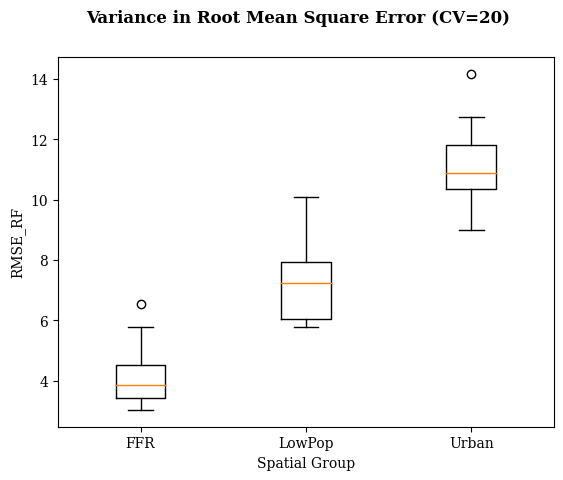

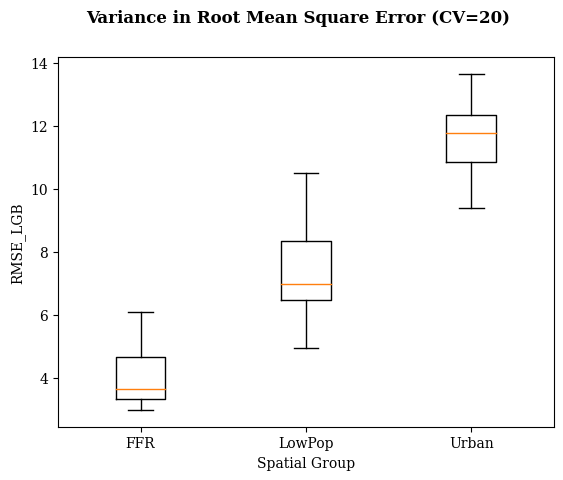

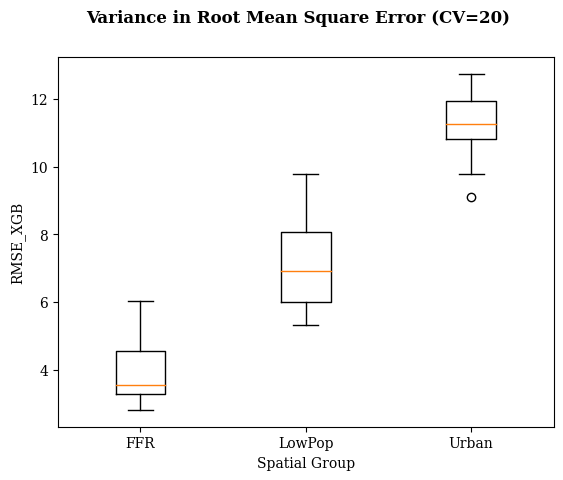

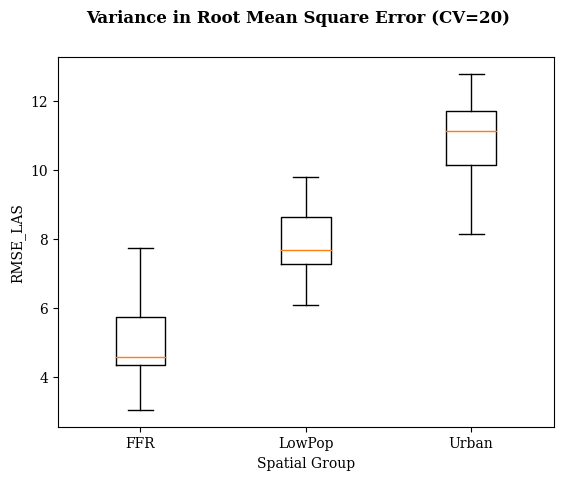

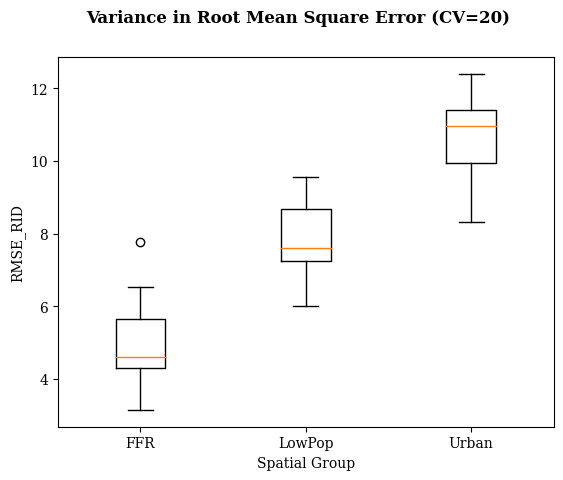

In [85]:
import matplotlib.pyplot as plt
i=0
j=0
while i < len(PIV_Models_RMSE):
    
    #define font
    plt.rcParams["font.family"] = "serif"
    
    fig = plt.figure()
    fig.suptitle('Variance in Root Mean Square Error (CV=20)', fontsize=12, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(PIV_Models_RMSE[i])

    ax.set_xticks([1, 2, 3], ['FFR', 'LowPop', 'Urban'])

    ax.set_xlabel('Spatial Group')
    ax.set_ylabel(PIV_Models_RMSE_names[j])
    fig.savefig(PIV_Models_RMSE_names[j] + '.jpg',  bbox_inches='tight',
           facecolor=(1, 1, 1))
    plt.show()
    i+=1
    j+=1

## R2

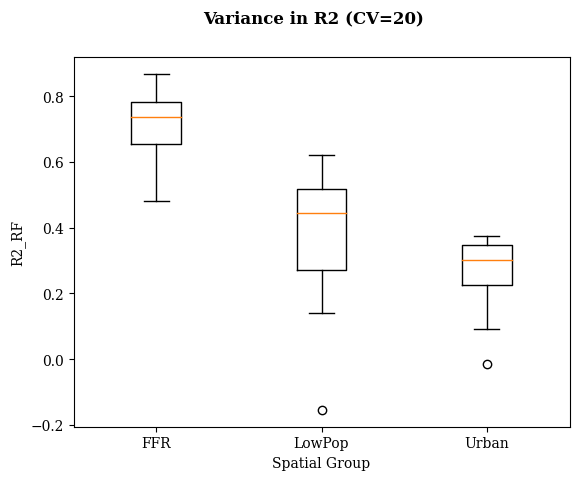

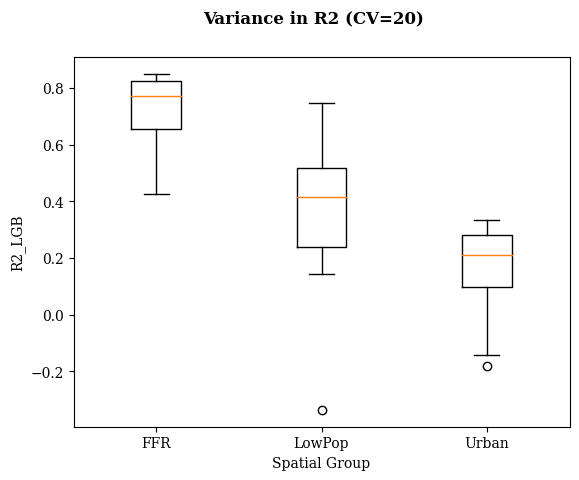

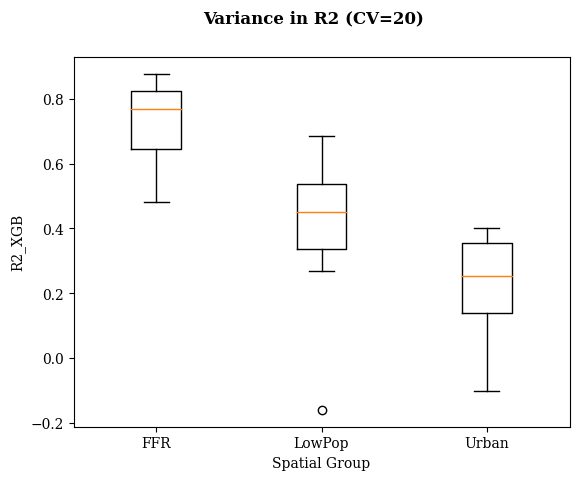

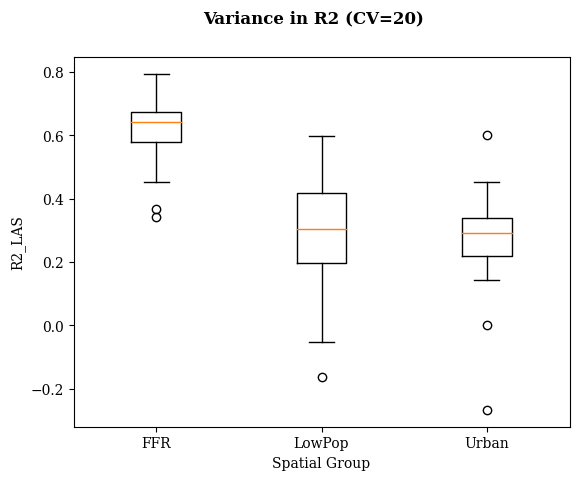

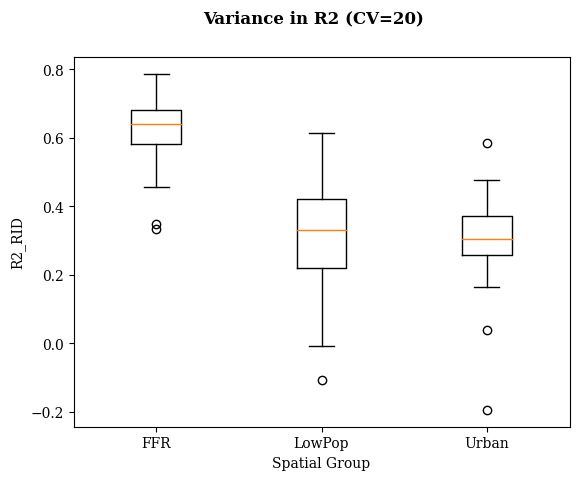

In [86]:
import matplotlib.pyplot as plt
i=0
j=0
while i < len(PIV_Models_R2):
    
    #define font
    plt.rcParams["font.family"] = "serif"
    
    fig = plt.figure()
    fig.suptitle('Variance in R2 (CV=20)', fontsize=12, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(PIV_Models_R2[i])

    ax.set_xticks([1, 2, 3], ['FFR', 'LowPop', 'Urban'])

    ax.set_xlabel('Spatial Group')
    ax.set_ylabel(PIV_Models_R2_names[j])
    fig.savefig(PIV_Models_R2_names[j] + '.jpg', bbox_inches='tight',
           facecolor=(1, 1, 1))
    plt.show()
    i+=1
    j+=1

## MAE

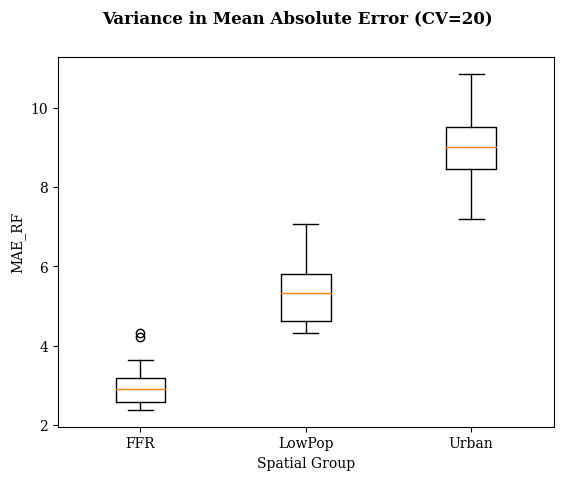

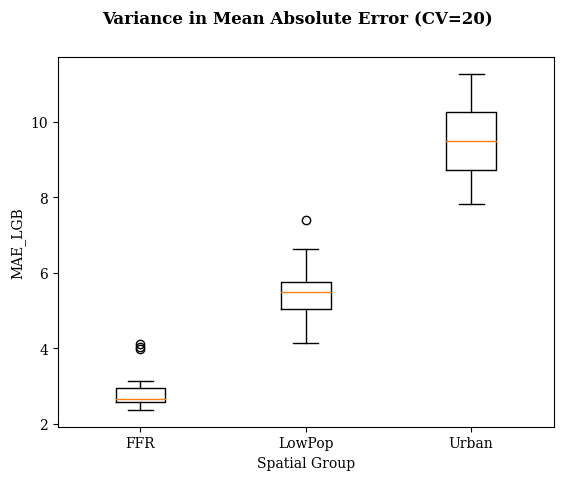

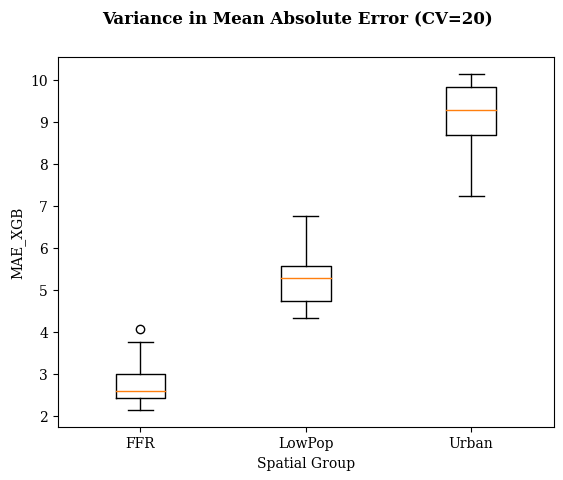

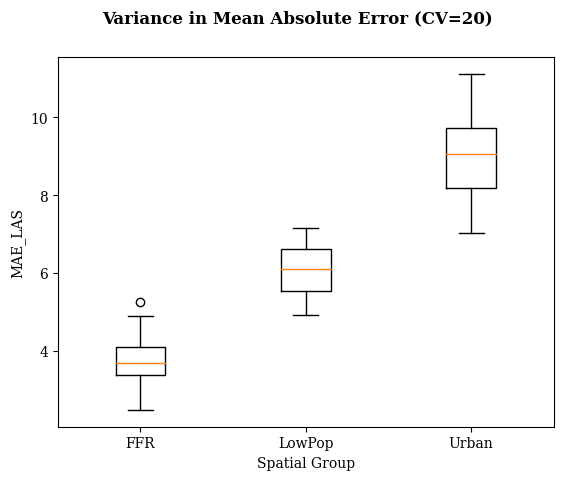

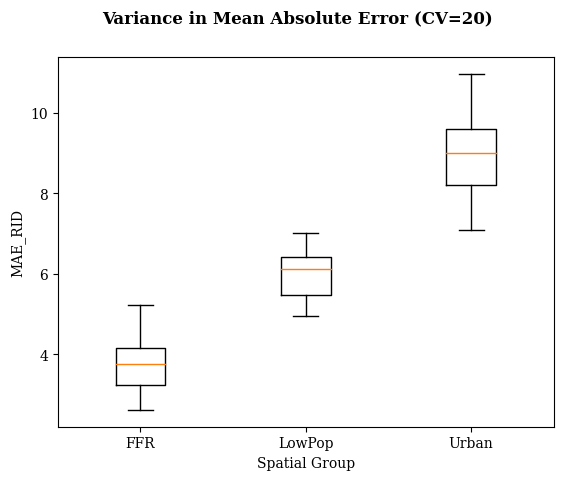

In [87]:
import matplotlib.pyplot as plt
i=0
j=0
while i < len(PIV_Models_MAE):
    #define font
    plt.rcParams["font.family"] = "serif"
    
    fig = plt.figure()
    fig.suptitle('Variance in Mean Absolute Error (CV=20)', fontsize=12, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(PIV_Models_MAE[i])

    ax.set_xticks([1, 2, 3], ['FFR', 'LowPop', 'Urban'])

    ax.set_xlabel('Spatial Group')
    ax.set_ylabel(PIV_Models_MAE_names[j])
    fig.savefig(PIV_Models_MAE_names[j] + '.jpg', bbox_inches='tight',
           facecolor=(1, 1, 1))

    plt.show()
    i+=1
    j+=1

## Export option

In [88]:
PIV_Models_RMSE = [RMSE_RF_PIV,  RMSE_LGB_PIV, RMSE_XGB_PIV, RMSE_LAS_PIV, RMSE_RID_PIV]
PIV_Models_RMSE_names = ['RMSE_RF',  'RMSE_LGB', 'RMSE_XGB', 'RMSE_LAS', 'RMSE_RID']
PIV_Models_R2 = [R2_RF_PIV,  R2_LGB_PIV , RF_XGB_PIV, R2_LAS_PIV, R2_RID_PIV]
PIV_Models_R2_names = ['R2_RF',  'R2_LGB' ,'R2_XGB', 'R2_LAS', 'R2_RID']
PIV_Models_MAE = [MAE_RF_PIV,  MAE_LGB_PIV , MAE_XGB_PIV, MAE_LAS_PIV, MAE_RID_PIV]
PIV_Models_MAE_names = ['MAE_RF', 'MAE_LGB' , 'MAE_XGB', 'MAE_LAS', 'MAE_RID']

In [89]:
RMSE_RF_PIV.to_excel('RMSE_RF_spachar.xlsx')
RMSE_LGB_PIV.to_excel('RMSE_LGB_spachar.xlsx')
RMSE_XGB_PIV.to_excel('RMSE_XGB_spachar.xlsx')
RMSE_LAS_PIV.to_excel('RMSE_LAS_spachar.xlsx')
RMSE_RID_PIV.to_excel('RMSE_RID_spachar.xlsx')

R2_RF_PIV.to_excel('R2_RF_spachar.xlsx')
R2_LGB_PIV.to_excel('R2_LGB_spachar.xlsx')
RF_XGB_PIV.to_excel('R2_XGB_spachar.xlsx')
R2_LAS_PIV.to_excel('R2_LAS_spachar.xlsx')
R2_RID_PIV.to_excel('R2_RID_spachar.xlsx')

MAE_RF_PIV.to_excel('MAE_RF_spachar.xlsx')
MAE_LGB_PIV.to_excel('MAE_LGB_spachar.xlsx')
MAE_XGB_PIV.to_excel('MAE_XGB_spachar.xlsx')
MAE_LAS_PIV.to_excel('MAE_LAS_spachar.xlsx')
MAE_RID_PIV.to_excel('MAE_RID_spachar.xlsx')

In [90]:
# df_urban.to_excel('df_urban-data23May.xlsx')
# df_lowpop.to_excel('df_lowpop-data23May.xlsx')
# df_farfromroad.to_excel('df_farfromroad-data23May.xlsx')

In [91]:
# pd.set_option('display.max_rows', None)
# df_1 = df['Distance_Below_100'] == 1

In [92]:
# print(df_1)

In [93]:
# import matplotlib.pyplot as plt
# # Creating plot
# plt.boxplot(df['population_1000'])

In [94]:
# df_filter = df[['population_1000', 'dist', 'road_class_3_100', 'Urban']]

In [95]:
# df_filter.to_excel('testdata23May.xlsx')